# APS1070
#### Basic Principles and Models - Project 1
**Deadline: Oct 1, 9PM - 10 percent**

**Academic Integrity**

This project is individual - it is to be completed on your own. If you have questions, please post your query in the APS1070 Piazza Q&A forums (the answer might be useful to others!).

Do not share your code with others, or post your work online. Do not submit code that you have not written yourself. Students suspected of plagiarism on a project, midterm or exam will be referred to the department for formal discipline for breaches of the Student Code of Conduct.

Name: shubowan  *(here and elsewhere, please replace the underscore with your answer)*

Student ID: 1007826907

##**Marking Scheme:**

This project is worth **10 percent** of your final grade.

Draw a plot or table where necessary to summarize your findings. 

**Practice Vectorized coding**: If you need to write a loop in your solution, think about how you can implement the same functionality with vectorized operations. Try to avoid loops as much as possible (in some cases, loops are inevitable).


 <font color='red'>**Remember to push your work on GitHub and share the link of your private repo on Quercus.**</font> 




# Project 1 [10 Marks] 
Let's apply the tools we have learned in the tutorial to a new dataset.

We're going to work with a breast cancer dataset. Download it using the cell below:

In [2]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

## Part 1: Getting started [2 Marks]
First off, take a look at the `data`, `target` and `feature_names` entries in the `dataset` dictionary. They contain the information we'll be working with here. Then, create a Pandas DataFrame called `df` containing the data and the targets, with the feature names as column headings. If you need help, see [here](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) for more details on how to achieve this. **[0.4]**
* How many features do we have in this dataset? ___30
* How many observations have a 'mean area' of greater than 700? ___171
* How many participants tested `Malignant`? __212_
* How many participants tested `Benign`? __357_

### Splitting the data
It is best practice to have a training set (from which there is a rotating validation subset) and a test set. Our aim here is to (eventually) obtain the best accuracy we can on the test set (we'll do all our tuning on the training/validation sets, however.) 

**Split the dataset** into a train and a test set **"70:30"**, use **``random_state=0``**. The test set is set aside (untouched) for final evaluation, once hyperparameter optimization is complete. **[0.5]**

In [3]:
### YOUR CODE HERE ###
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
df=pd.DataFrame(dataset.data,columns=dataset.feature_names)
df["target"]=dataset.target
X=dataset.data
y=dataset.target
X_train,X_test,y_train,y_test=train_test_split(X,y,train_size=0.7,random_state=0)
dataset.feature_names.size
sum(dataset.target),dataset.target.size-sum(dataset.target)
sum(df['mean area'].values>700)

171

### Effect of Standardization (Visual)
Use `seaborn.lmplot` ([help here](https://seaborn.pydata.org/generated/seaborn.lmplot.html)) to visualize a few features of the training set. Draw a plot where the x-axis is ``worst smoothness``, the y-axis is ``worst fractal dimension,`` and the color of each datapoint indicates its class.  **[0.5]**

Standardizing the data is often critical in machine learning. Show a plot as above, but with two features with very different scales. Standardize the data and plot those features again. What's different? Based on your observation, what is the advantage of standardization? **[0.6]**
After standardization,the scale of x-axis and y-axis is simillar. Standardization can help balance the influence of two features. Before that the mean area is much larger than the smoothness error and it will affect the result more than smoothness error when we compute the distance.




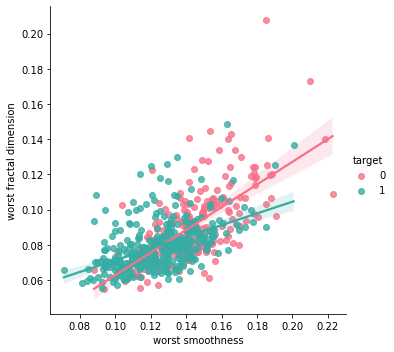

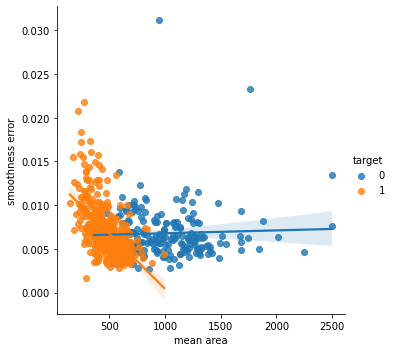

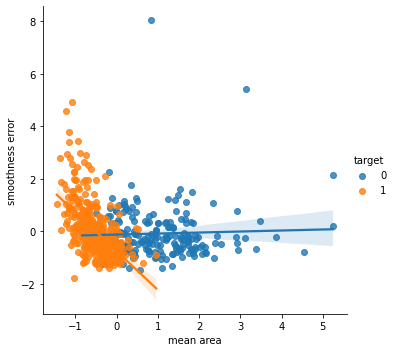

In [4]:
### YOUR CODE HERE ###
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import copy
sns.lmplot(x='worst smoothness',y='worst fractal dimension',data=df,hue='target',palette='husl')
sns.lmplot(x='mean area',y='smoothness error',data=df,hue='target')
df_norm=copy.deepcopy(df)
x=np.array([df_norm['mean area'].values,df_norm['smoothness error'].values])
scaler=StandardScaler()
scaler.fit(x.T)
x_norm=scaler.transform(x.T)
df_norm['mean area']=x_norm[:,0]
df_norm['smoothness error']=x_norm[:,1]
sns.lmplot(x='mean area',y='smoothness error',data=df_norm,hue='target')

## Part 2: KNN Classifier without Standardization [2 Marks]
Normally, standardizing data is a key step in preparing data for a KNN classifier. However, for educational purposes, let's first try to build a model without standardization. Let's create a KNN classifier to predict whether a patient has a malignant or benign tumor. 

Follow these steps: 

1.   Train a KNN Classifier using cross-validation on the dataset. Sweep `k` (number of neighbours) from 1 to 100, and show a plot of the mean cross-validation accuracy vs `k`. **[1]**
2.   What is the best `k`? What is the highest cross-validation accuracy? **[0.5]**  9  0.9346518987341772
3. Comment on  which ranges of `k` lead to underfitted or overfitted models (hint: compare training and validation curves!). **[0.5]**   k from about 0 to 8 lead to overfitted




In [5]:
### YOUR CODE HERE ###
from sklearn import neighbors
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
x_k=[0]*100 
y_test_scores=[0]*100
y_train_scores=[0]*100
for k in range(1,101):
  knn=neighbors.KNeighborsClassifier(n_neighbors=k)
  scores = cross_validate(knn, X_train, y_train, cv=5,return_train_score=True)
  x_k[k-1]=k
  y_train_scores[k-1]=scores['train_score'].mean()
  y_test_scores[k-1]=scores['test_score'].mean()

(9, 0.9346518987341772)

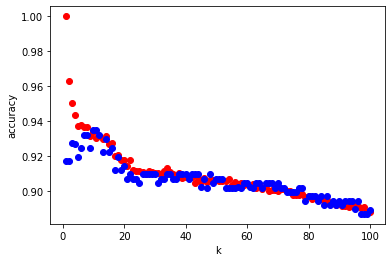

In [6]:
plt.xlabel('k')
plt.ylabel('accuracy')
plt.plot(x_k,y_train_scores,'ro',x_k,y_test_scores,'bo')
highest_accuracy=max(y_test_scores)
best_k=y_test_scores.index(highest_accuracy)
best_k,highest_accuracy

## Part 3: Feature Selection [4 Marks]
In this part, we aim to investigate the importance of each feature on the final classification accuracy. 
If we want to try every possible combination of features, we would have to test  $2^F$ different cases,  where F is the number of features, and in each case, we have to do a hyperparameter search (finding K, in KNN using cross-validation). That will take days!. 

To find more important features we will use a decision tree. based on a decision tree we can compute feature importance that is a metric for our feature selection (code is provided below).

You can use the following link to get familiar with extracting the feature impotance order of machine learning algorithms in Python: 

https://machinelearningmastery.com/calculate-feature-importance-with-python/

After we identified and removed the least important feature and evaluated a new KNN model on the new set of features, if the stop conditions (see step 7 below) are not met, we need to remove another feature. To do that we fit a new decision tree to the remaining features and identify the least important feature. 


Design a function ( `Feature_selector`) that accepts your dataset (X_train , y_train) and a threshold as inputs and: **[3]**
1. Fits a decision tree classifier on the training set.

2. Extracts the feature importance order of the decision tree model.

3. Each time, removes the least important feature based on step 2. 
4. Then, a KNN model is trained on the remaining features. The number of neighbors (`k`) for each KNN model should be tuned using a 5-fold cross-validation.
5. Store the best `mean cross-validation` score and the corresponding `k` (number of neighbours) value in two lists.
6. Go back to step 1, fit a new tree on the reduced dataset and follow all the steps until you meet the stop condition. 
 
7. We will stop this process when (1) there is only one feature left, or (2) our cross-validation accuracy is dropped significantly compared to a model that uses all the features. In this function, we accept a threshold as an input argument. For example, if threshold=0.95 we do not continue removing features if our mean cross-validation accuracy after tuning `k` is bellow **0.95 $\times$ Full Feature cross-validation accuracy**.

8. Your function returns the list of removed features, and the corresponding mean cross-validation accuracy and `k` value when a feature was removed.

* Visualize your results by plotting the mean cross-validation accuracy (with a tuned `k` on y axis) vs. the number of features (x axis). This plot describes: what is the best cv score with 1 feature, 2 features, 3 features ... and all the features. **[0.5]**

* Plot the best value of `k` (y-axis) vs. the number of features. This plot explains the trend of number of neighbours with respect to the number of features.  **[0.5]**

  
  







 

You can use the following piece of code to start training a decision tree classifier and obtain its feature importance order. 
```
from sklearn import tree
dt = tree.DecisionTreeClassifier()
dt.fit(X_train,y_train)
importance = dt.feature_importances_
```


In [7]:

from sklearn import tree  
def Feature_selector (X_train , y_train , tr=0.95):
  List_removed=[]
  List_feature=df.columns
  h_accuracy=0
  for k in range(1,101):
      knn=neighbors.KNeighborsClassifier(n_neighbors=k)
      scores = cross_validate(knn, X_train, y_train, cv=5)
      if h_accuracy<scores['test_score'].mean():
        h_accuracy=scores['test_score'].mean()
        b_k=k 
  List_removed.append(['full feature',b_k,h_accuracy])
  while(X_train.shape[1]>1 and h_accuracy>0.95*0.9346518987341772):
    dt = tree.DecisionTreeClassifier(random_state=0)
    dt.fit(X_train,y_train)
    importance = dt.feature_importances_
    for feature,score in enumerate(importance):
      if score==min(importance):
        X_train=np.delete(X_train,feature,1)
        fea_removed=List_feature[feature]
        List_feature=np.delete(List_feature,feature)
        break
    h_accuracy=0
    b_k=0
    for k in range(1,101):
      knn=neighbors.KNeighborsClassifier(n_neighbors=k)
      scores = cross_validate(knn, X_train, y_train, cv=5)
      if h_accuracy<scores['test_score'].mean():
        h_accuracy=scores['test_score'].mean()
        b_k=k 
    List_removed.append([fea_removed,b_k,h_accuracy])
  return List_removed

In [8]:
List_result=Feature_selector(X_train,y_train)

[['full feature' '10' '0.9346518987341772']
 ['mean radius' '10' '0.9346518987341772']
 ['mean texture' '10' '0.9346518987341772']
 ['mean area' '34' '0.9145886075949367']
 ['mean smoothness' '34' '0.9145886075949367']
 ['mean compactness' '34' '0.9145886075949367']
 ['mean perimeter' '34' '0.9145886075949367']
 ['mean concavity' '34' '0.9145886075949367']
 ['mean concave points' '34' '0.9145886075949367']
 ['mean fractal dimension' '34' '0.9145886075949367']
 ['texture error' '34' '0.9145886075949367']
 ['perimeter error' '34' '0.9145886075949367']
 ['compactness error' '34' '0.9145886075949367']
 ['concavity error' '34' '0.9145886075949367']
 ['smoothness error' '34' '0.9145886075949367']
 ['concave points error' '34' '0.9145886075949367']
 ['symmetry error' '34' '0.9145886075949367']
 ['worst perimeter' '61' '0.9145569620253164']
 ['worst smoothness' '61' '0.9145569620253164']
 ['worst fractal dimension' '61' '0.9145569620253164']
 ['worst radius' '61' '0.9145569620253164']
 ['fract

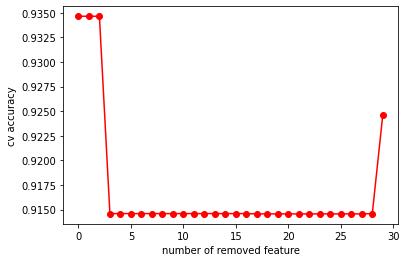

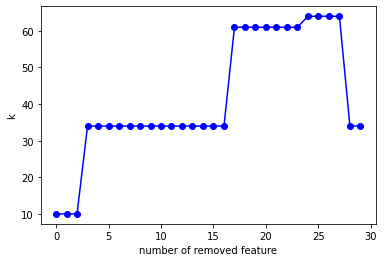

In [18]:

x1=[i for i in range(0,30)]
List_result=np.array(List_result)
y1=[np.float(i) for i in List_result[:,2]]
y2=[np.float(i) for i in List_result[:,1]]
plt.figure()
plt.xlabel('number of removed feature')
plt.ylabel('cv accuracy')
plt.plot(x1,y1,'ro-')
plt.figure()
plt.xlabel('number of removed feature')
plt.ylabel('k')
plt.plot(x1,y2,'bo-')
print(List_result)
print(dataset.feature_names)

## Part 4: Standardization [1.5 Marks]

Standardizing the data usually means scaling our data to have a mean of zero and a standard deviation of one. 

**Note:** When we standardize a dataset, do we care if the data points are in our training set or test set? Yes! The training set is available for us to train a model - we can use it however we want. The test set, however, represents a subset of data that is not available for us during training. For example, the test set can represent the data that someone who bought our model would use to see how the model performs (which they are not willing to share with us).
Therefore, we cannot compute the mean or standard deviation of the whole dataset to standardize it - we can only calculate the mean and standard deviation of the training set. However, when we sell a model to someone, we can say what our scalers (mean and standard deviation of our training set) was. They can scale their data (test set) with our training set's mean and standard deviation. Of course, there is no guarantee that the test set would have a mean of zero and a standard deviation of one, but it should work fine.

**To summarize: We fit the StandardScaler only on the training set. We transform both training and test sets with that scaler.**

1. Standardize the training  and test data ([Help](https://scikit-learn.org/stable/modules/preprocessing.html)) **[0.5]**

2. Call your ``Feature_selector`` function on the standardized training data with a threshold of 0.95\%.  **[0.5]**
 * Plot the Cross validation accuracy when we have the standardized data (this part) and the original training data (last part) vs. the Number of features in a single plot (to compare them easily).

3. Discuss how standardization (helped/hurt) your model and its performance? Discuss which cases lead to a higher cross validation accuracy (how many features? which features? What K?) **[0.5]**
Standardization helped improve the model's accuracy a lot. It balanced the influence of different features on training and help us tell their real importance order in classifying the samples. In the case when I have 30 features and k=10, it leads to the highest accuracy. However, when the random_state in decision tree changes, the number of features and k of the best accuracy may change which depends on the random decisions of some steps in the algorithm of decision tree.


In [10]:
from sklearn import preprocessing
### YOUR CODE HERE ###
scaler=preprocessing.StandardScaler()
scaler.fit(X_train)
X_train_scaled=scaler.transform(X_train)
X_test_scaled=scaler.transform(X_test)

In [11]:
List_result_scaled=Feature_selector(X_train_scaled,y_train)

In [12]:
print(List_result_scaled)

[['full feature', 10, 0.9674367088607594], ['mean radius', 8, 0.9649683544303798], ['mean texture', 4, 0.9623417721518986], ['mean area', 5, 0.9623417721518986], ['mean smoothness', 6, 0.9572784810126581], ['mean compactness', 7, 0.9598417721518986], ['mean perimeter', 7, 0.9623417721518986], ['mean concavity', 7, 0.9573101265822783], ['mean concave points', 8, 0.9573101265822785], ['mean fractal dimension', 7, 0.9548101265822785], ['texture error', 7, 0.9573417721518988], ['perimeter error', 8, 0.9573417721518986], ['compactness error', 3, 0.9572784810126581], ['concavity error', 8, 0.9598101265822784], ['smoothness error', 8, 0.9648734177215189], ['concave points error', 4, 0.9673417721518988], ['symmetry error', 6, 0.9623417721518986], ['worst perimeter', 8, 0.9623417721518986], ['worst smoothness', 6, 0.9674050632911392], ['worst fractal dimension', 7, 0.9648734177215189], ['worst radius', 9, 0.9598101265822784], ['fractal dimension error', 13, 0.9598417721518986], ['radius error',

best accuracy: 0.9674367088607594 k: 10 number of features: 30
features: ['mean radius' 'mean texture' 'mean area' 'mean smoothness'
 'mean compactness' 'mean perimeter' 'mean concavity'
 'mean concave points' 'mean fractal dimension' 'texture error'
 'perimeter error' 'compactness error' 'concavity error'
 'smoothness error' 'concave points error' 'symmetry error'
 'worst perimeter' 'worst smoothness' 'worst fractal dimension'
 'worst radius' 'fractal dimension error' 'radius error'
 'worst compactness' 'worst texture' 'mean symmetry' 'worst symmetry'
 'worst concavity' 'area error' 'worst area' 'worst concave points']


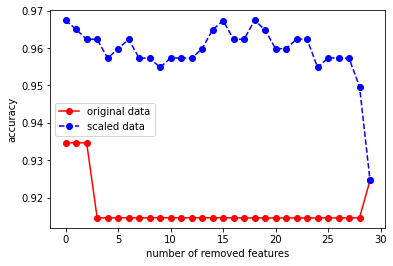

In [23]:
x_scaled=[i for i in range(0,30)]
List_result_scaled=np.array(List_result_scaled)
y_scaled=[np.float(i) for i in List_result_scaled[:,2]]
plt.xlabel('number of removed features')
plt.ylabel('accuracy')
plt.plot(x1,y1,'ro-',label='original data')
plt.plot(x_scaled,y_scaled,'bo--',label='scaled data')
plt.legend()
best_accuracy=max(List_result_scaled[:,2])
best_index=np.where(List_result_scaled==best_accuracy)[0]
best_k=List_result_scaled[best_index,1][0]
print('best accuracy:',best_accuracy,'k:',best_k,'number of features:',30-best_index[0])
List_feature_left=np.insert(List_result_scaled,30,['worst concave points',0,0],0)
print('features:',List_feature_left[best_index[0]+1:,0])

## Part 5: Test Data [0.5 Mark]

Now that you've created several models, pick your best one (highest CV accuracy) and apply it to the test dataset you had initially set aside. Discuss your results. **[0.5]**
The final accuracy of prediction of test set is 0.959,it's higher than the result of using unstandardized data. It may be better than results of cases using different numbers of features, but it's possible to exist cases which have higher accuracy since different random seed causes different results. Some of them may be more suitable for the test set than the current model, but the differences will not be remarkable.

In [14]:
index_removed=[]
for i in range(1,best_index[0]+1):
  index=np.where(dataset.feature_names==List_result_scaled[i,0])[0]
  index_removed.append(index[0])
X_test_scaled_fearemoved=np.delete(X_test_scaled,index_removed,1)
X_train_scaled_fearemoved=np.delete(X_train_scaled,index_removed,1)

In [25]:
knn=neighbors.KNeighborsClassifier(n_neighbors=int(best_k))
knn.fit(X_train_scaled_fearemoved,y_train)
Z=knn.predict(X_test_scaled_fearemoved)
accuracy=knn.score(X_test_scaled_fearemoved,y_test)
print(accuracy)

0.9590643274853801


References:

https://towardsdatascience.com/decision-trees-in-machine-learning-641b9c4e8052

https://www.analyticsvidhya.com/blog/2021/02/machine-learning-101-decision-tree-algorithm-for-classification/